In [1]:
from collections import defaultdict
from typing import  List, Literal
import pandas as pd
from src.pipe_store import *
import matplotlib.pyplot as plt
from scipy.stats import iqr

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
def LoadMFI(path):
    dtype = {
        'TransplantID': 'int32',
        'LocusLong': 'category',
        'Locus': 'category',
        'SerologicalEquivalent': 'category',
        'ManConcl_Immucor': 'category',
    }
    usecols = [
        'TransplantID', 'LocusLong', 'Locus', 'Specificity', 
        'SerologicalEquivalent', 'MedianFI', 'TMeanFI',	'ManConcl_Immucor']
    df = pd.read_csv(path, sep=';', dtype=dtype, usecols=usecols)
    df['Specificity'] = df['Specificity'].apply(lambda x: set(x.split(',')))
    for col in ['MedianFI', 'TMeanFI']:          
        df[col] = (df[col]
                    .apply(lambda x: x.replace(',', '.'))
                    .astype('float32')
                    .astype('int')
        )
    # Finally drop the HLA's belonging to DP group 
    return df[df['Locus'] != 'DP']

def get_mfi_per_hla(df_mfi, tx_id:int, hla:str, cut_off:int) -> dict:
    _dict = dict()
    for _, item in df_mfi[df_mfi['TransplantID'] == tx_id].iterrows():
            if hla in item['Specificity'] and item['ManConcl_Immucor'] == 'Positive':
                if item['TMeanFI'] >= cut_off:
                    _dict[hla]= {'MedianFI': item['MedianFI'], 'TMeanFI': item['TMeanFI']}
    return _dict

df_mfi = LoadMFI('~/Global Data/RawData/MFI.csv')
df_mfi.sample(2)

,TransplantID,LocusLong,Locus,Specificity,SerologicalEquivalent,MedianFI,TMeanFI,ManConcl_Immucor
44709,2040,A,A,{A*68:02},A68,1734,1801,Positive
71343,2743,DQB1,DQ,"{DQB1*04:01, DQA1*02:01}",DQ4,117,122,Negative


In [3]:
df_mfi.describe()

,TransplantID,MedianFI,TMeanFI
count,189470.000000,189470.000000,189470.000000
mean,2426.733646,1303.444308,1344.340592
std,1825.334839,3255.081630,3285.041872
min,1.000000,0.000000,23.000000
25%,672.000000,128.000000,135.000000
50%,2185.000000,199.000000,213.000000
75%,3967.000000,503.000000,548.000000
max,6102.000000,22213.000000,21780.000000


In [4]:
path = '~/Global Data/20210614-mismatch_ep_db-extended.pickle'
donor_type ='Deceased'
status = 'All'

df = (
    data_loading(path)
    .pipe(start_pipeline, status, donor_type)
    .pipe(keeping_features,
        'Failure',
        'Survival[Y]',
        'TransplantID',
        'EpvsHLA_Donor',
        '#DESA',
        'DESA', 
    )
    .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
    .pipe(setting_prediction_horizon, 15)
)
epitope_path = '~/Global Data/EpitopevsHLA.pickle'
epitope_db = pd.read_pickle(epitope_path)

In [5]:
def assign_mfi(inputs, cut_off:int) -> dict:
    # print(inputs)
    tx_id = inputs['TransplantID']
    epvshla = inputs['EpvsHLA_Donor']
    return [get_mfi_per_hla(df_mfi, tx_id, hla, cut_off) for hla in epvshla.values()]

cut_off = 0
df['MFI'] = df[df['#DESA'] > 0][['TransplantID', 'EpvsHLA_Donor']].apply(assign_mfi, args=(cut_off,), axis=1)

In [6]:
df[df['#DESA'] > 0][['EpvsHLA_Donor', 'MFI']].iloc[2].values

array([{'13SE': 'DRB3*03:01', '181T': 'DRB3*03:01', '37N': 'DRB1*13:02', '31FH': 'DRB3*03:01', '71E': 'DRB1*13:02', '180VTP': 'DRB3*03:01', '32H': 'DRB3*03:01', '140TV': 'DRB3*03:01', '96HK': 'DRB1*13:02', '25R': 'DRB3*03:01', '74A': 'DRB1*13:02', '47F': 'DRB1*13:02', '4R': 'DRB3*03:01', '98KS': 'DRB1*13:02', '149H': 'DRB3*03:01', '11STS': 'DRB1*13:02', '70DA': 'DRB1*13:02', '28D': 'DRB1*13:02', '98Q': 'DRB3*03:01', '70Q': 'DRB3*03:01', '70QK': 'DRB3*03:01', '70QQ': 'DRB3*03:01', '77N[DR]': 'DRB3*03:01', '67LQ': 'DRB3*03:01', '71K': 'DRB3*03:01'},
       list([{'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {}, {'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {}, {'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {}, {'DRB3*03:01': {'MedianFI': 18337, 'TMeanFI': 18267}}, {}, {}, {'DRB3*03:01': {'MedianFI': 

In [7]:
def get_weighted_mfi(mfis:List[dict], on:Literal['TMeanFI', 'MedianFI']) -> int:
    hold = []
    for mfi in mfis:
        if mfi:
            for _, value in mfi.items():
                hold.append(value[on])
    if len(hold):
        return int(sum(hold)/len(hold))
    return 0
    # return sum([value['TMeanFI'] for mfi in mfis if mfi for _, value in _dict.items()])

df['WeightedMFI'] = df[df['#DESA'] > 0]['MFI'].apply(lambda x: get_weighted_mfi(x, on='TMeanFI'))

In [8]:
# get_mfi_per_hla(df_mfi, 710, 0)
# df_mfi[(df_mfi.TransplantID == 710) & (df_mfi.ManConcl_Immucor == 'Positive')]

In [9]:
# epitope_db[epitope_db.Epitope == '156QA']['Luminex Alleles']

# Plot Heatmap

## Early failure

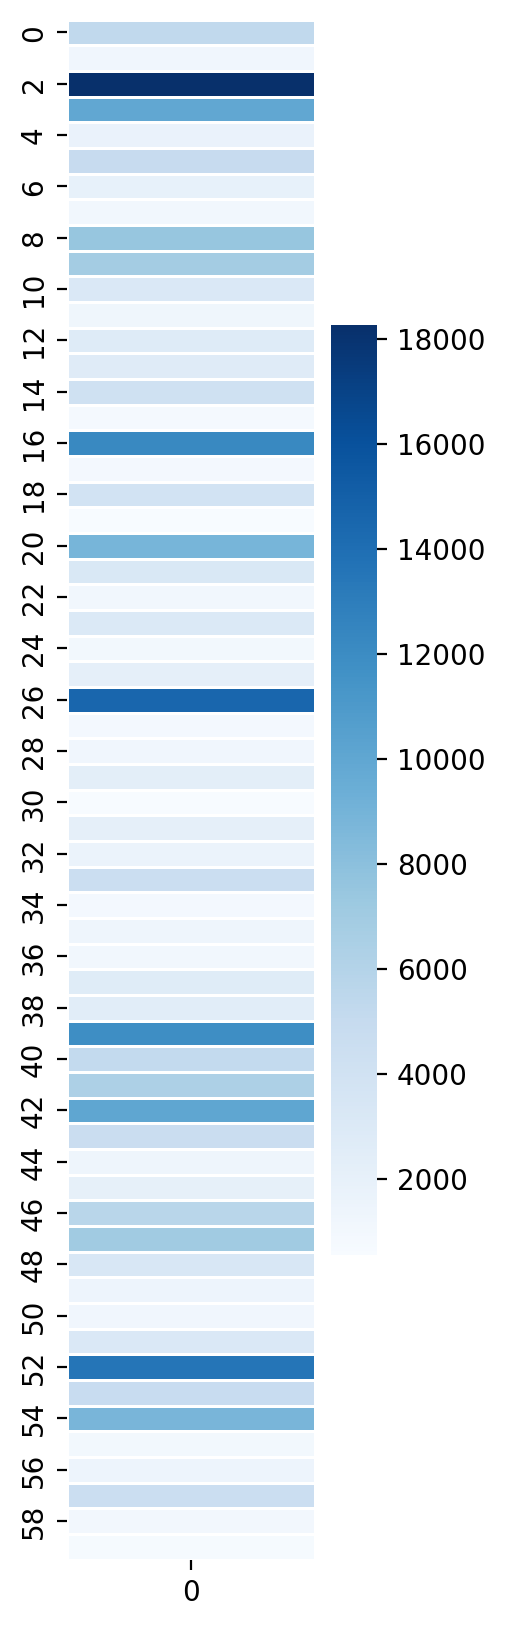

In [10]:
import seaborn as sns
plt.figure(figsize=(2, 10))
df_final = df[(df['#DESA'] > 0) & (df['WeightedMFI'] != 0)]
df_final = df_final.sort_values(by='T')
# df_final['WeightedMFI'] = (df_final['WeightedMFI'] - df_final['WeightedMFI'].mean()) / df_final['WeightedMFI'].std()
# df_final['WeightedMFI_Scaled'] = (df_final['WeightedMFI'] - df_final['WeightedMFI'].min()) / (df_final['WeightedMFI'].max() - df_final['WeightedMFI'].min())
plot_values = df_final[(df_final['E'] == 1) & (df_final['T'] < 1)]['WeightedMFI'].values.reshape(-1,1)

ax = sns.heatmap(plot_values, linewidth=0.5, cmap='Blues')
plt.show()

In [11]:
df_final[(df_final['E'] == 1) & (df_final['T'] < 1)].shape

(60, 8)

In [12]:
print(f"Mean (SD): {np.mean(plot_values):.0f} ({np.std(plot_values):.0f})")
print(f"Median (IQR): {np.median(plot_values):.0f} ({iqr(plot_values):.0f})")

Mean (SD): 4133 (3906)
Median (IQR): 2710 (3954)


## Late failure

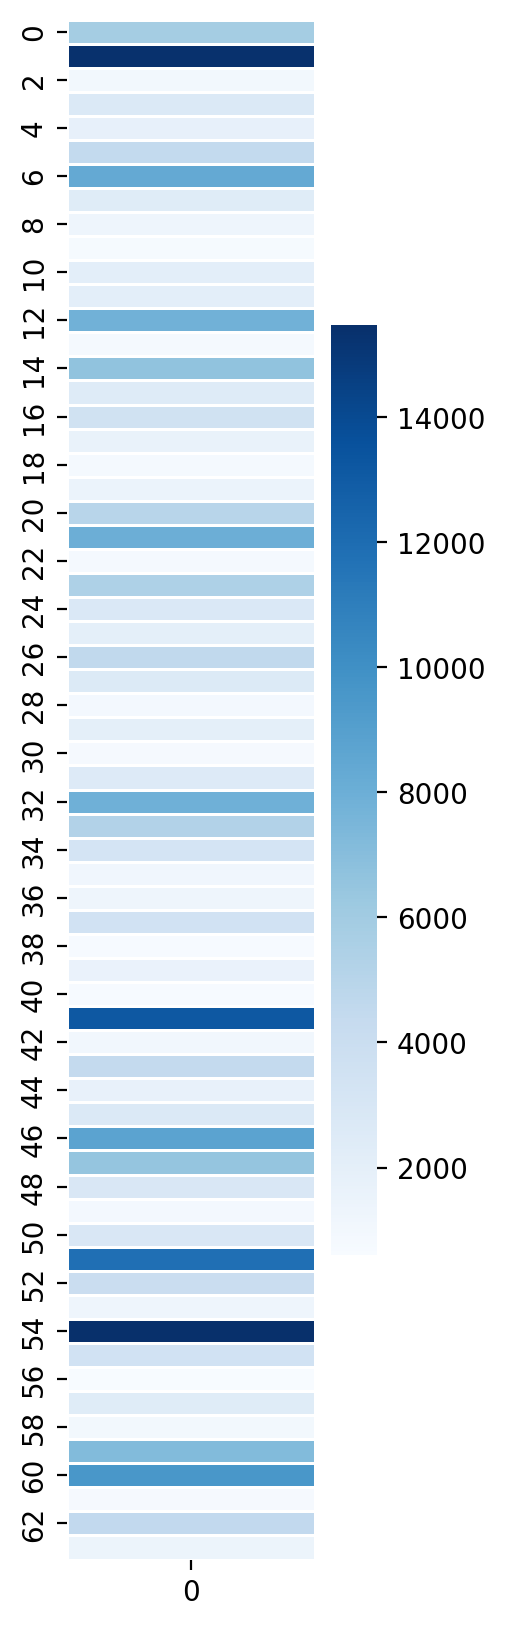

In [13]:
import seaborn as sns
plt.figure(figsize=(2, 10))
df_final = df[(df['#DESA'] > 0) & (df['WeightedMFI'] != 0)]
df_final = df_final.sort_values(by='T')
# df_final['WeightedMFI'] = (df_final['WeightedMFI'] - df_final['WeightedMFI'].mean()) / df_final['WeightedMFI'].std()
# df_final['WeightedMFI_Scaled'] = (df_final['WeightedMFI'] - df_final['WeightedMFI'].min()) / (df_final['WeightedMFI'].max() - df_final['WeightedMFI'].min())
plot_values = df_final[(df_final['E'] != 1) & (df_final['T'] > 12)]['WeightedMFI'].values.reshape(-1,1)
ax = sns.heatmap(plot_values, linewidth=0.5, cmap='Blues')
plt.show()

In [14]:
df_final[(df_final['E'] != 1) & (df_final['T'] > 12)].shape

(64, 8)

In [15]:
print(f"Mean (SD): {np.mean(plot_values):.0f} ({np.std(plot_values):.0f})")
print(f"Median (IQR): {np.median(plot_values):.0f} ({iqr(plot_values):.0f})")

Mean (SD): 3841 (3525)
Median (IQR): 2580 (3748)


# Plot Kaplan-Meier Curves

In [16]:
df_new['#DESA'].apply(lambda x: 1 if x else 0).sum()

NameError: name 'df_new' is not defined